<a href="https://colab.research.google.com/github/asmaaabdelsattar/instant-training/blob/main/BrainMRISegmantation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tqdm import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
dataset_path = '/content/drive/MyDrive/BrainMRISegmentation/lgg-mri-segmentation/kaggle_3m'

# Automatically collect all image and mask paths
all_images = []
all_masks = []

for folder in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder)
    if os.path.isdir(folder_path):
        for file in os.listdir(folder_path):
            if file.endswith(".tif"):
                file_path = os.path.join(folder_path, file)
                if "_mask" in file:
                    all_masks.append(file_path)
                else:
                    all_images.append(file_path)

print("Total MRI images:", len(all_images))
print("Total segmentation masks:", len(all_masks))

Total MRI images: 3929
Total segmentation masks: 3929


In [9]:
# Load a sample subset for training
IMG_SIZE = 128
X = []
Y = []

for img_path in tqdm(all_images[:1000]):
    mask_path = img_path.replace(".tif", "_mask.tif")
    if os.path.exists(mask_path):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        X.append(img)
        Y.append(mask)

X = np.array(X) / 255.0
Y = np.array(Y) / 255.0
Y = np.expand_dims(Y, axis=-1)

print("X shape:", X.shape)
print("Y shape:", Y.shape)


100%|██████████| 1000/1000 [13:07<00:00,  1.27it/s]


X shape: (1000, 128, 128)
Y shape: (1000, 128, 128, 1)


In [26]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

In [11]:
# STEP 6: Build U-Net model
def build_unet(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(16, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(32, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(64, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(128, (3,3), activation='relu', padding='same')(c4)
    p4 = MaxPooling2D((2,2))(c4)

    # Bottleneck
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(p4)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    # Decoder
    u6 = UpSampling2D((2,2))(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = UpSampling2D((2,2))(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    u8 = UpSampling2D((2,2))(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(u8)
    c8 = Conv2D(32, (3,3), activation='relu', padding='same')(c8)

    u9 = UpSampling2D((2,2))(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(u9)
    c9 = Conv2D(16, (3,3), activation='relu', padding='same')(c9)

    outputs = Conv2D(1, (1,1), activation='sigmoid')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    return model

model = build_unet()
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │      2,320 │ conv2d[0][0]      │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_4[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │    147,584 │ conv2d_6[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 8, 8, 128) │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 8, 8, 256) │    295,168 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 8, 8, 256) │    590,080 │ conv2d_8[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 16, 16,    │          0 │ conv2d_9[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 16, 16,    │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 1,962,337 (7.49 MB)

 Trainable params: 1,962,337 (7.49 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
    ModelCheckpoint('best_unet_model.h5', save_best_only=True)
]

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=16,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9866 - loss: 0.5239

50/50 ━━━━━━━━━━━━━━━━━━━━ 171s 3s/step - accuracy: 0.9867 - loss: 0.5200 - val_accuracy: 0.9910 - val_loss: 0.0904 - learning_rate: 1.0000e-04
Epoch 2/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9900 - loss: 0.0748

50/50 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0.9900 - loss: 0.0745 - val_accuracy: 0.9910 - val_loss: 0.0406 - learning_rate: 1.0000e-04
Epoch 3/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9907 - loss: 0.0382

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9907 - loss: 0.0382 - val_accuracy: 0.9910 - val_loss: 0.0355 - learning_rate: 1.0000e-04
Epoch 4/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9902 - loss: 0.0376

50/50 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9902 - loss: 0.0376 - val_accuracy: 0.9910 - val_loss: 0.0341 - learning_rate: 1.0000e-04
Epoch 5/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 199s 3s/step - accuracy: 0.9898 - loss: 0.0368 - val_accuracy: 0.9910 - val_loss: 0.0349 - learning_rate: 1.0000e-04
Epoch 6/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9903 - loss: 0.0352

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9903 - loss: 0.0352 - val_accuracy: 0.9910 - val_loss: 0.0320 - learning_rate: 1.0000e-04
Epoch 7/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9901 - loss: 0.0340

50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9901 - loss: 0.0340 - val_accuracy: 0.9910 - val_loss: 0.0319 - learning_rate: 1.0000e-04
Epoch 8/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9897 - loss: 0.0349

50/50 ━━━━━━━━━━━━━━━━━━━━ 151s 3s/step - accuracy: 0.9897 - loss: 0.0349 - val_accuracy: 0.9910 - val_loss: 0.0317 - learning_rate: 1.0000e-04
Epoch 9/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 153s 3s/step - accuracy: 0.9896 - loss: 0.0360 - val_accuracy: 0.9910 - val_loss: 0.0321 - learning_rate: 1.0000e-04
Epoch 10/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9898 - loss: 0.0337

50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9898 - loss: 0.0337 - val_accuracy: 0.9910 - val_loss: 0.0301 - learning_rate: 1.0000e-04
Epoch 11/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9905 - loss: 0.0294 - val_accuracy: 0.9910 - val_loss: 0.0313 - learning_rate: 1.0000e-04
Epoch 12/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9894 - loss: 0.0334

50/50 ━━━━━━━━━━━━━━━━━━━━ 155s 3s/step - accuracy: 0.9894 - loss: 0.0334 - val_accuracy: 0.9910 - val_loss: 0.0288 - learning_rate: 1.0000e-04
Epoch 13/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9898 - loss: 0.0308 - val_accuracy: 0.9910 - val_loss: 0.0295 - learning_rate: 1.0000e-04
Epoch 14/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9896 - loss: 0.0314

50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9896 - loss: 0.0314 - val_accuracy: 0.9910 - val_loss: 0.0277 - learning_rate: 1.0000e-04
Epoch 15/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9901 - loss: 0.0300

50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9900 - loss: 0.0300 - val_accuracy: 0.9910 - val_loss: 0.0268 - learning_rate: 1.0000e-04
Epoch 16/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9906 - loss: 0.0277

50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9906 - loss: 0.0277 - val_accuracy: 0.9910 - val_loss: 0.0254 - learning_rate: 1.0000e-04
Epoch 17/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9904 - loss: 0.0260

50/50 ━━━━━━━━━━━━━━━━━━━━ 198s 3s/step - accuracy: 0.9904 - loss: 0.0260 - val_accuracy: 0.9910 - val_loss: 0.0221 - learning_rate: 1.0000e-04
Epoch 18/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9903 - loss: 0.0224 - val_accuracy: 0.9914 - val_loss: 0.0245 - learning_rate: 1.0000e-04
Epoch 19/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9907 - loss: 0.0231

50/50 ━━━━━━━━━━━━━━━━━━━━ 149s 3s/step - accuracy: 0.9907 - loss: 0.0230 - val_accuracy: 0.9925 - val_loss: 0.0216 - learning_rate: 1.0000e-04
Epoch 20/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9921 - loss: 0.0212

50/50 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.9921 - loss: 0.0211 - val_accuracy: 0.9934 - val_loss: 0.0179 - learning_rate: 1.0000e-04
Epoch 21/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9935 - loss: 0.0181

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9935 - loss: 0.0181 - val_accuracy: 0.9933 - val_loss: 0.0162 - learning_rate: 1.0000e-04
Epoch 22/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9941 - loss: 0.0155 - val_accuracy: 0.9919 - val_loss: 0.0240 - learning_rate: 1.0000e-04
Epoch 23/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9935 - loss: 0.0169

50/50 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9935 - loss: 0.0169 - val_accuracy: 0.9944 - val_loss: 0.0149 - learning_rate: 1.0000e-04
Epoch 24/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 150s 3s/step - accuracy: 0.9936 - loss: 0.0161 - val_accuracy: 0.9943 - val_loss: 0.0160 - learning_rate: 1.0000e-04
Epoch 25/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9947 - loss: 0.0135

50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9947 - loss: 0.0135 - val_accuracy: 0.9949 - val_loss: 0.0133 - learning_rate: 1.0000e-04
Epoch 26/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9951 - loss: 0.0121

50/50 ━━━━━━━━━━━━━━━━━━━━ 152s 3s/step - accuracy: 0.9951 - loss: 0.0121 - val_accuracy: 0.9951 - val_loss: 0.0127 - learning_rate: 1.0000e-04
Epoch 27/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9949 - loss: 0.0121 - val_accuracy: 0.9941 - val_loss: 0.0167 - learning_rate: 1.0000e-04
Epoch 28/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 148s 3s/step - accuracy: 0.9949 - loss: 0.0122 - val_accuracy: 0.9947 - val_loss: 0.0137 - learning_rate: 1.0000e-04
Epoch 29/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9954 - loss: 0.0107

50/50 ━━━━━━━━━━━━━━━━━━━━ 202s 3s/step - accuracy: 0.9954 - loss: 0.0107 - val_accuracy: 0.9954 - val_loss: 0.0113 - learning_rate: 5.0000e-05
Epoch 30/30
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9959 - loss: 0.0092

50/50 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.9959 - loss: 0.0092 - val_accuracy: 0.9954 - val_loss: 0.0105 - learning_rate: 5.0000e-05


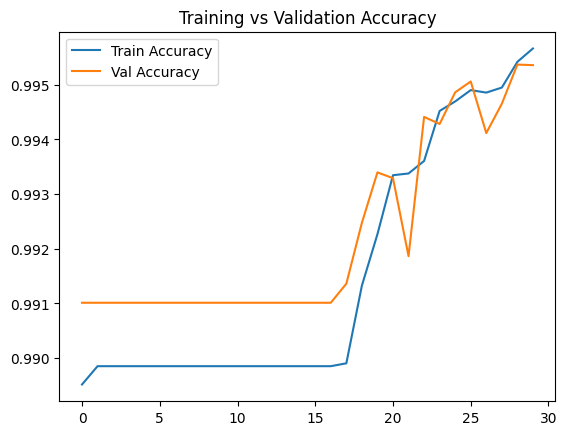

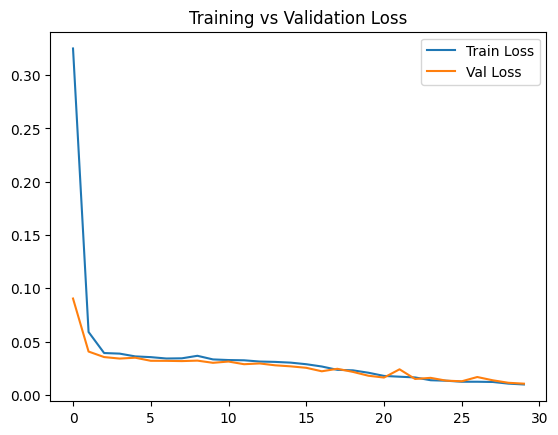

In [13]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


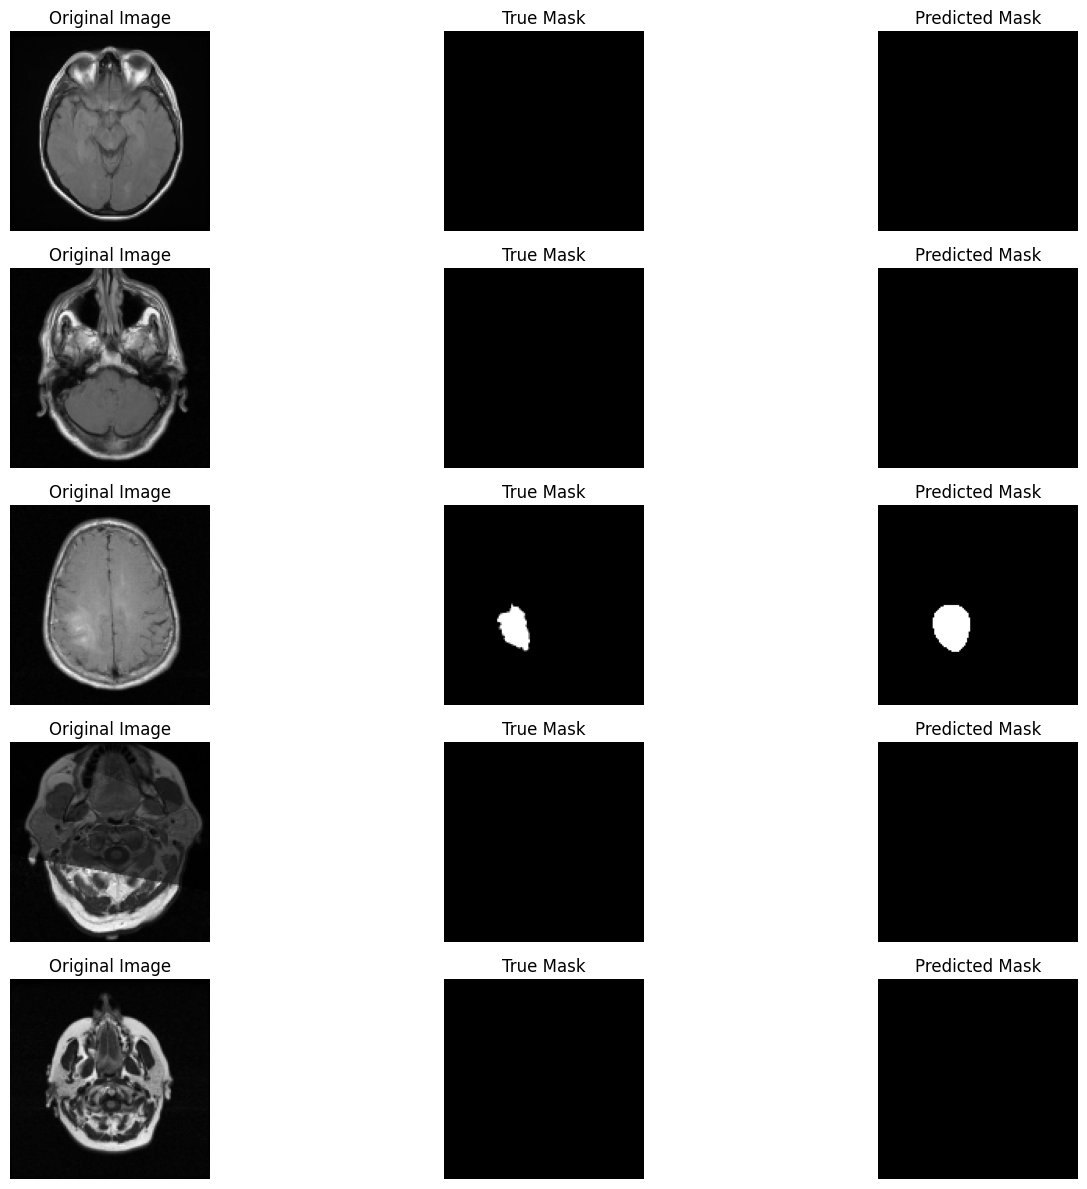

In [19]:
preds = model.predict(X_val[:5])

plt.figure(figsize=(15, 12))
for i in range(5):
    # Original Image
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X_val[i].squeeze(), cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # True Mask
    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(Y_val[i].squeeze(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(preds[i].squeeze() > 0.5, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [20]:
non_empty_masks = [np.sum(Y_val[i]) for i in range(len(Y_val))]
non_empty_count = np.sum(np.array(non_empty_masks) > 0)
print(f"{non_empty_count} out of {len(Y_val)} validation samples have tumors.")


63 out of 200 validation samples have tumors.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


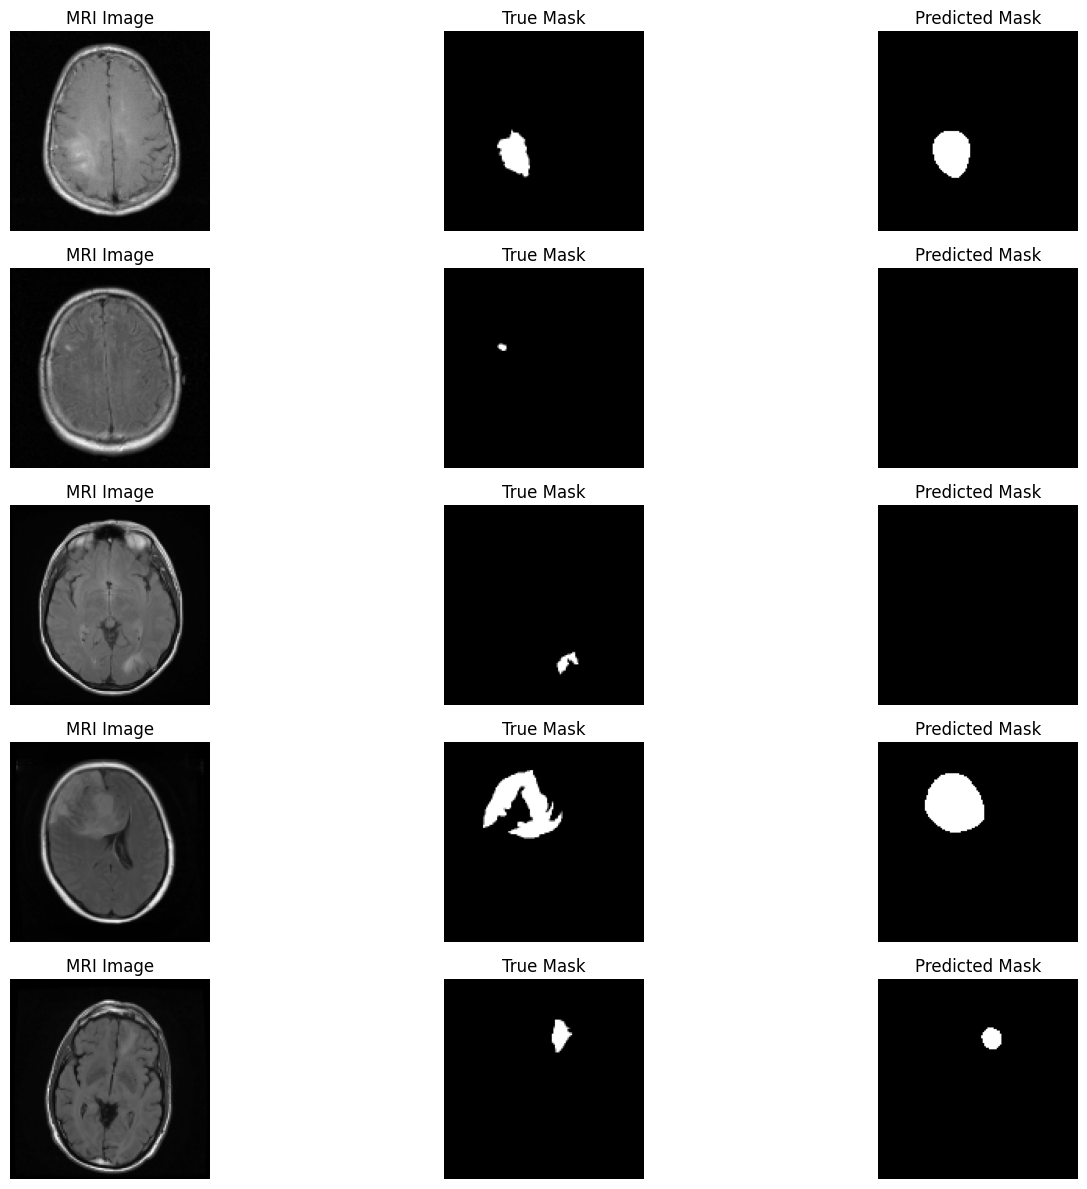

In [21]:
# Find indices that have tumor areas
tumor_indices = [i for i in range(len(Y_val)) if np.sum(Y_val[i]) > 0]

# Display 5 tumor slices
plt.figure(figsize=(15, 12))
for i, idx in enumerate(tumor_indices[:5]):
    plt.subplot(5, 3, i*3 + 1)
    plt.imshow(X_val[idx].squeeze(), cmap='gray')
    plt.title('MRI Image')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 2)
    plt.imshow(Y_val[idx].squeeze(), cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    plt.subplot(5, 3, i*3 + 3)
    plt.imshow(model.predict(np.expand_dims(X_val[idx], axis=0))[0].squeeze() > 0.5, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

plt.tight_layout()
plt.show()
